# Monte Carlo Investment Simulation — Single Asset Model

This notebook simulates possible future portfolio values by generating a large number of random return paths based on an assumed expected annual return and volatility.

This is useful to understand:
- the range of potential outcomes (best case to worst case)
- the most likely median growth path
- how volatility affects long-term investment results

### Key Idea:
Instead of predicting ONE exact result, Monte Carlo gives a probability distribution of possible results — which is more realistic for financial forecasting.


In [3]:
# ---------------------------------------------
# Monte Carlo Investment Simulation (Single Asset)
# Step 1: Setup + Inputs
# ---------------------------------------------
# This cell imports libraries & defines assumptions.
# You can edit assumptions here any time.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- User Adjustable Variables ---
initial_investment = 10000      # starting amount
years = 10                      # length of investment
num_simulations = 1000          # how many Monte Carlo trials

# Return assumptions (annualized)
mean_return = 0.08              # expected average annual return (8%)
std_dev = 0.15                  # standard deviation of returns (15%)

In [4]:
# ---------------------------------------------
# Step 2: Run Simulation
# ---------------------------------------------
# In this step I generate simulated portfolio paths.
# Each simulation represents a possible future outcome.
# Annual returns are randomly drawn from a normal distribution
# based on the mean + standard deviation I set above.

# time dimension (1 value per year)
t = np.arange(0, years + 1)

# matrix to hold all simulations
# rows = years, columns = different simulation paths
simulations = np.zeros((years + 1, num_simulations))

# set initial starting value across all simulations
simulations[0] = initial_investment

# simulation loop
for i in range(1, years + 1):  
    # draw random annual returns based on normal distribution assumptions
    random_returns = np.random.normal(mean_return, std_dev, num_simulations)

    # compute next year portfolio values
    simulations[i] = simulations[i - 1] * (1 + random_returns)


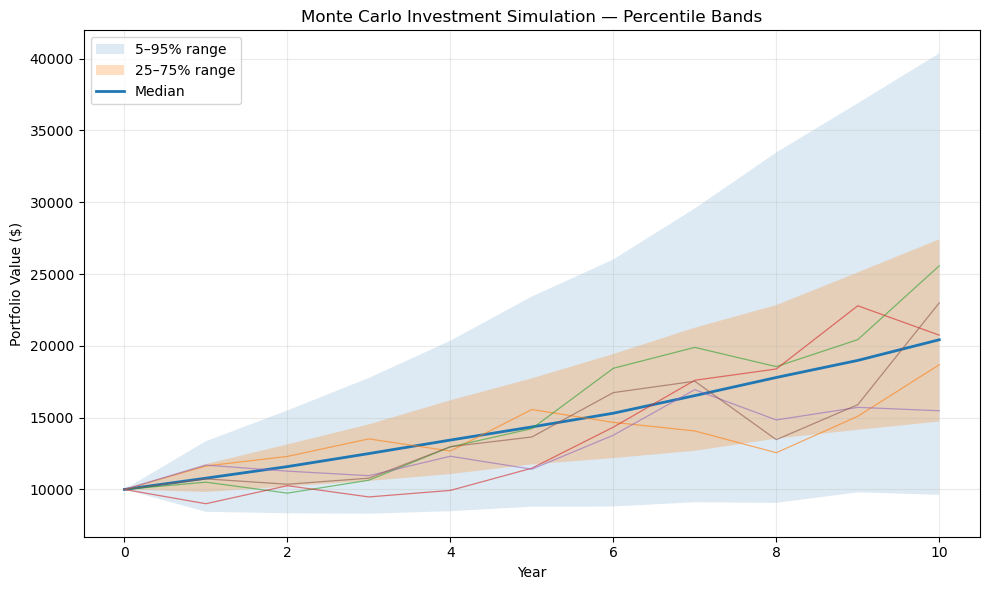

In [5]:
# ---------------------------------------------
# Step 3: Compute percentiles and plot the distribution
# ---------------------------------------------
# Here I summarize the cloud of paths into 5 key percentiles
# at each year (5th, 25th, 50th, 75th, 95th) and plot them.
# I also overlay a few random sample paths for intuition.

# compute percentiles across the simulation axis (columns)
p05 = np.percentile(simulations, 5,  axis=1)
p25 = np.percentile(simulations, 25, axis=1)
p50 = np.percentile(simulations, 50, axis=1)   # median path
p75 = np.percentile(simulations, 75, axis=1)
p95 = np.percentile(simulations, 95, axis=1)

# plot: shaded bands + median + a few sample paths
plt.figure(figsize=(10,6))

# shaded uncertainty bands
plt.fill_between(t, p05, p95, alpha=0.15, label="5–95% range")
plt.fill_between(t, p25, p75, alpha=0.25, label="25–75% range")

# median path
plt.plot(t, p50, linewidth=2, label="Median")

# overlay 5 random sample paths from the simulation
sample_idx = np.random.choice(simulations.shape[1], size=min(5, simulations.shape[1]), replace=False)
plt.plot(t, simulations[:, sample_idx], linewidth=0.9, alpha=0.6)

plt.title("Monte Carlo Investment Simulation — Percentile Bands")
plt.xlabel("Year")
plt.ylabel("Portfolio Value ($)")
plt.legend(loc="upper left")
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


# ---------------------------------------------
# Step 4: End-of-horizon stats and goal probability
# ---------------------------------------------
# This gives me quick numbers I can speak to:
# - median ending value, downside (5th pct), upside (95th pct)
# - probability of meeting a target amount by the final year

target = 500_000   # EDIT ME: financial goal at the final year (e.g., 500k)

end_values = simulations[-1]  # all simulations at final year

summary = {
    "Years": years,
    "Initial ($)": initial_investment,
    "Mean end ($)": float(np.mean(end_values)),
    "Median end ($)": float(np.median(end_values)),
    "5th pct end ($)": float(np.percentile(end_values, 5)),
    "25th pct end ($)": float(np.percentile(end_values, 25)),
    "75th pct end ($)": float(np.percentile(end_values, 75)),
    "95th pct end ($)": float(np.percentile(end_values, 95)),
    f"P(End ≥ {target:,.0f})": float(np.mean(end_values >= target)),
    "P(End < initial)": float(np.mean(end_values < initial_investment)),
}

# present as a neat one-row DataFrame
pd.DataFrame([summary]).T.rename(columns={0:"Value"})


### How to tweak this simulation
- `mean_return` — raises/lowers the drift (expected growth). Bigger → higher typical outcomes.
- `std_dev` — raises/lowers uncertainty. Bigger → wider bands, more downside AND upside.
- `years` — the horizon length. Longer → compounding dominates dispersion.
- `num_simulations` — more paths = smoother percentiles (but slower to run).
- `initial_investment` — starting value. Scales the whole distribution.

**Tip:** change one variable at a time and re-run cells 2 → 5.


In [8]:
# ---------------------------------------------
# Optional: rerun with return clipping to avoid impossible < -100% shocks
# ---------------------------------------------
# If std_dev is very high and years are many, normal draws can be extremely negative.
# This shows how to cap per-year loss at -90% just as a safety for toy scenarios.

clip_min = -0.90  # cap a single-year loss to -90% (you can change/remove this)

t = np.arange(0, years + 1)
simulations_clipped = np.zeros((years + 1, num_simulations))
simulations_clipped[0] = initial_investment

for i in range(1, years + 1):
    random_returns = np.random.normal(mean_return, std_dev, num_simulations)
    random_returns = np.maximum(random_returns, clip_min)  # clip very negative tails
    simulations_clipped[i] = simulations_clipped[i-1] * (1 + random_returns)

# quick compare of medians (original vs clipped)
median_orig = np.percentile(simulations[-1], 50)
median_clip = np.percentile(simulations_clipped[-1], 50)
print(f"Median end (original): ${median_orig:,.0f}")
print(f"Median end (clipped) : ${median_clip:,.0f}")


Median end (original): $20,422
Median end (clipped) : $19,948


## Add-On: Monthly Compounding with Contributions

Here I switch from 1 step per year to **12 steps per year** (monthly).  
I also allow a fixed contribution amount added **each month**.

**Assumptions:**
- Annual mean/vol are converted to per-month values.
- Simple return model (same as above, just smaller steps).
- Contribution is added after growth each month (common convention).

I can set `contrib_per_month = 0` to disable contributions.


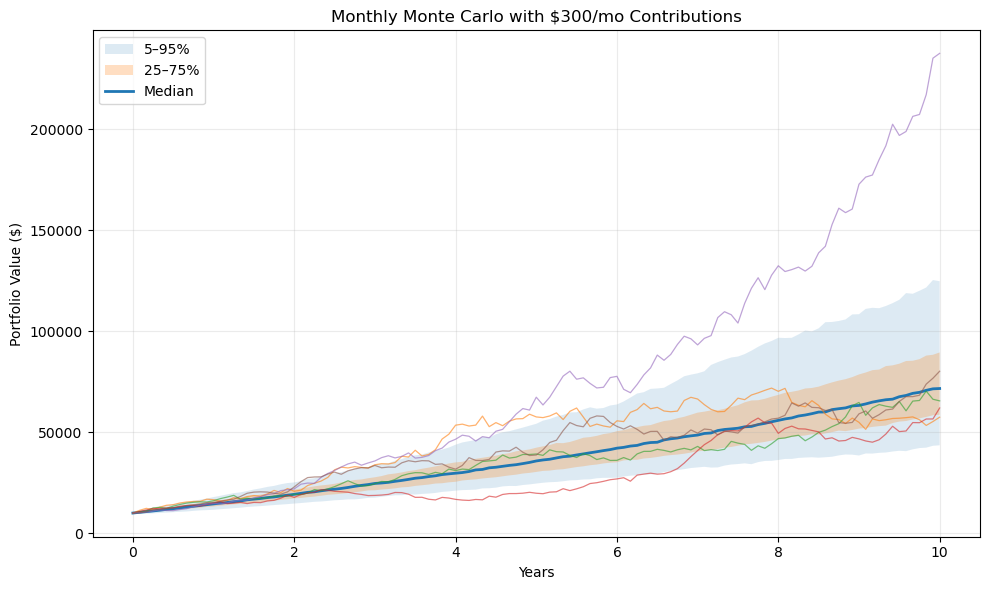

In [11]:
# ---------------------------------------------
# Add-On Step: Monthly compounding + contributions (simple returns)
# ---------------------------------------------
import numpy as np

months_per_year   = 12
total_months      = years * months_per_year

# USER KNOBS — edit these as you like
contrib_per_month = 300.0   # $ contribution each month (set 0 to disable)

# Convert annual mean/vol to monthly equivalents for a simple-return model
mu_m   = mean_return / months_per_year           # approximate monthly drift
sigma_m = std_dev / np.sqrt(months_per_year)     # monthly volatility

# Time axis in years for plotting (0..years in 1/12 steps)
t_months = np.arange(0, total_months + 1) / months_per_year

# Matrix for monthly paths
monte_monthly = np.zeros((total_months + 1, num_simulations))
monte_monthly[0] = initial_investment

for m in range(1, total_months + 1):
    # draw monthly simple returns
    r = np.random.normal(mu_m, sigma_m, num_simulations)
    # grow then contribute
    monte_monthly[m] = monte_monthly[m-1] * (1 + r) + contrib_per_month

# Percentiles at each month
mp05 = np.percentile(monte_monthly, 5,  axis=1)
mp25 = np.percentile(monte_monthly, 25, axis=1)
mp50 = np.percentile(monte_monthly, 50, axis=1)
mp75 = np.percentile(monte_monthly, 75, axis=1)
mp95 = np.percentile(monte_monthly, 95, axis=1)

# Plot
plt.figure(figsize=(10,6))
plt.fill_between(t_months, mp05, mp95, alpha=0.15, label="5–95%")
plt.fill_between(t_months, mp25, mp75, alpha=0.25, label="25–75%")
plt.plot(t_months, mp50, linewidth=2, label="Median")
# overlay a few sample paths
idx = np.random.choice(monte_monthly.shape[1], size=min(5, monte_monthly.shape[1]), replace=False)
plt.plot(t_months, monte_monthly[:, idx], linewidth=0.9, alpha=0.6)

plt.title(f"Monthly Monte Carlo with ${contrib_per_month:,.0f}/mo Contributions")
plt.xlabel("Years"); plt.ylabel("Portfolio Value ($)")
plt.legend(loc="upper left"); plt.grid(alpha=.25); plt.tight_layout()
plt.show()


## Optional: Fees and Inflation (Real Dollars)

Two small adjustments that make the model more realistic:

- **Expense ratio (annual)**: a constant fee drag (e.g., 0.20%/yr) applied each month.
- **Inflation (annual)**: convert nominal dollars into **real** (today’s) dollars.

**How:**  
- Fee drag becomes a monthly multiplier: `(1 - fee) ** (1/12)`.  
- Real dollars divide by `(1 + inflation) ** (t_years)`.


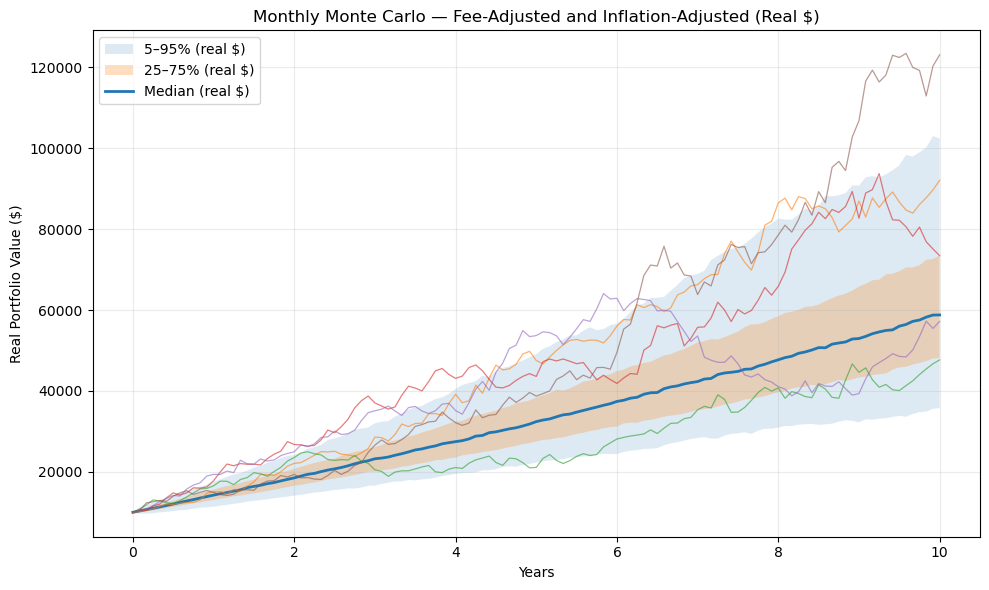

,Value
Median end (real $),58796.851681
5th pct end (real $),35740.221412
95th pct end (real $),102385.027518
P(End < initial in real $),0.000000


In [13]:
# ---------------------------------------------
# Optional Step: Convert monthly nominal paths to fee-adjusted, then real $
# ---------------------------------------------
annual_fee      = 0.002   # 0.20% per year (edit me)
annual_infl     = 0.02    # 2.0% inflation (edit me)

# Monthly equivalents
fee_month_mult = (1.0 - annual_fee) ** (1.0 / months_per_year)  # multiplicative fee factor per month
infl_month_mult = (1.0 + annual_infl) ** (1.0 / months_per_year)

# Make a copy of nominal paths to transform
paths_fee_nominal = monte_monthly.copy()

# Apply fee drag multiplicatively each month (except t=0)
for m in range(1, total_months + 1):
    paths_fee_nominal[m] = paths_fee_nominal[m] * fee_month_mult

# Convert to REAL dollars by dividing out cumulative inflation
# Build a vector of inflation multipliers at each month (length total_months+1)
infl_cumulative = (infl_month_mult ** np.arange(0, total_months + 1))[:, None]
paths_real = paths_fee_nominal / infl_cumulative

# Percentiles in real dollars
rp05 = np.percentile(paths_real, 5,  axis=1)
rp25 = np.percentile(paths_real, 25, axis=1)
rp50 = np.percentile(paths_real, 50, axis=1)
rp75 = np.percentile(paths_real, 75, axis=1)
rp95 = np.percentile(paths_real, 95, axis=1)

# Plot (REAL $)
plt.figure(figsize=(10,6))
plt.fill_between(t_months, rp05, rp95, alpha=0.15, label="5–95% (real $)")
plt.fill_between(t_months, rp25, rp75, alpha=0.25, label="25–75% (real $)")
plt.plot(t_months, rp50, linewidth=2, label="Median (real $)")

# overlay sample real-dollar paths
idx = np.random.choice(paths_real.shape[1], size=min(5, paths_real.shape[1]), replace=False)
plt.plot(t_months, paths_real[:, idx], linewidth=0.9, alpha=0.6)

plt.title("Monthly Monte Carlo — Fee-Adjusted and Inflation-Adjusted (Real $)")
plt.xlabel("Years"); plt.ylabel("Real Portfolio Value ($)")
plt.legend(loc="upper left"); plt.grid(alpha=.25); plt.tight_layout()
plt.show()

# Quick end-of-horizon stats (real $)
end_real = paths_real[-1]
pd.DataFrame([{
    "Median end (real $)": float(np.median(end_real)),
    "5th pct end (real $)": float(np.percentile(end_real, 5)),
    "95th pct end (real $)": float(np.percentile(end_real, 95)),
    "P(End < initial in real $)": float(np.mean(end_real < initial_investment))
}]).T.rename(columns={0:"Value"})


## Interactive Sliders (ipywidgets)

These controls let me change assumptions live and re-run the **monthly** Monte Carlo:

- **μ (mean return)** and **σ (volatility)** are annualized.
- Sliders convert annual inputs to **monthly** internally.
- I can toggle **contributions**, **fees**, and **inflation**.
- Optional: **lock random seed** so charts are comparable when I tweak one parameter.

**If widgets don’t appear:**  
Run once in a terminal:
- `pip install ipywidgets`
- Classic Notebook: `jupyter nbextension enable --py widgetsnbextension`
- JupyterLab v3+ usually needs no extra step. Then restart the kernel and re-run.


In [15]:
# ---------------------------------------------
# Interactive Sliders for Monthly Monte Carlo (with contributions)
# ---------------------------------------------
# This cell:
# 1) defines a clean monthly simulator function with options for fees/inflation
# 2) builds ipywidgets sliders
# 3) re-runs the simulation and replots when I move a slider
#
# Notes for me:
# - All inputs are annualized, converted to monthly internally.
# - If "Lock seed" is ON, results are deterministic for the same parameters.

import numpy as np
import matplotlib.pyplot as plt

try:
    from ipywidgets import interact, FloatSlider, IntSlider, Checkbox, HBox, VBox, Layout
    from IPython.display import clear_output, display
except Exception as e:
    print("ipywidgets not available. Install with `pip install ipywidgets` and restart the kernel.")
    raise

def simulate_monthly_mc(
    initial=10_000.0,
    years=30,
    n_sims=1000,
    mu_annual=0.07,
    sigma_annual=0.15,
    contrib_month=300.0,
    apply_fees=False,
    fee_annual=0.002,
    apply_infl=False,
    infl_annual=0.02,
    lock_seed=False,
    seed=42,
):
    """Run a monthly Monte Carlo under simple returns with optional contributions, fees, and inflation."""
    if lock_seed:
        np.random.seed(seed)

    mpy = 12
    total_m = years * mpy

    # Convert annual to monthly
    mu_m = mu_annual / mpy                    # simple monthly drift approx
    sig_m = sigma_annual / np.sqrt(mpy)       # monthly vol

    # Allocate paths
    paths = np.zeros((total_m + 1, n_sims), dtype=float)
    paths[0] = initial

    # Draw all shocks at once (vectorized)
    shocks = np.random.normal(loc=mu_m, scale=sig_m, size=(total_m, n_sims))

    # Fee factor per month (multiplicative) and inflation per month
    fee_mult_m  = (1.0 - fee_annual) ** (1.0/mpy) if apply_fees else 1.0
    infl_mult_m = (1.0 + infl_annual) ** (1.0/mpy) if apply_infl else 1.0

    # Evolve paths
    for m in range(1, total_m + 1):
        # grow by simple monthly return
        paths[m] = paths[m-1] * (1.0 + shocks[m-1])
        # monthly contribution after growth
        if contrib_month != 0.0:
            paths[m] += contrib_month
        # apply fee drag (if enabled)
        if apply_fees:
            paths[m] *= fee_mult_m

    # If inflation enabled, convert to REAL dollars by dividing cumulative inflation
    if apply_infl:
        infl_cum = (infl_mult_m ** np.arange(0, total_m + 1))[:, None]
        paths = paths / infl_cum

    # Time axis in years
    t_years = np.arange(0, total_m + 1) / mpy
    return t_years, paths

def summarize(paths, initial):
    """Return percentiles and a dict of end-of-horizon summary stats."""
    p05 = np.percentile(paths, 5,  axis=1)
    p25 = np.percentile(paths, 25, axis=1)
    p50 = np.percentile(paths, 50, axis=1)
    p75 = np.percentile(paths, 75, axis=1)
    p95 = np.percentile(paths, 95, axis=1)

    end = paths[-1]
    summ = {
        "Median end": float(np.median(end)),
        "5th pct end": float(np.percentile(end, 5)),
        "95th pct end": float(np.percentile(end, 95)),
        "P(End < initial)": float(np.mean(end < initial)),
    }
    return (p05, p25, p50, p75, p95), summ

def plot_paths(t, paths, pcts, title_suffix=""):
    """Plot percentile bands + a few sample paths, cleanly."""
    p05, p25, p50, p75, p95 = pcts

    plt.figure(figsize=(10,6))
    # shaded bands
    plt.fill_between(t, p05, p95, alpha=0.15, label="5–95%")
    plt.fill_between(t, p25, p75, alpha=0.25, label="25–75%")
    # median
    plt.plot(t, p50, linewidth=2, label="Median")
    # samples
    k = min(5, paths.shape[1])
    if k > 0:
        idx = np.random.choice(paths.shape[1], size=k, replace=False)
        plt.plot(t, paths[:, idx], linewidth=0.9, alpha=0.6)

    plt.title(f"Monthly Monte Carlo{title_suffix}")
    plt.xlabel("Years"); plt.ylabel("Portfolio Value")
    plt.legend(loc="upper left"); plt.grid(alpha=.25); plt.tight_layout()
    plt.show()

# ---------- Widgets ----------
w_initial   = FloatSlider(value=float(initial_investment if 'initial_investment' in globals() else 10_000),
                          min=0, max=200_000, step=500, readout_format='.0f',
                          description='Initial ($):', layout=Layout(width='400px'))
w_years     = IntSlider(value=int(years if 'years' in globals() else 30),
                        min=1, max=50, step=1, description='Years:', layout=Layout(width='400px'))
w_nsims     = IntSlider(value=int(num_simulations if 'num_simulations' in globals() else 1000),
                        min=100, max=10000, step=100, description='# Sims:', layout=Layout(width='400px'))

w_mu        = FloatSlider(value=float(mean_return if 'mean_return' in globals() else 0.07),
                          min=-0.10, max=0.20, step=0.005, description='μ (annual):', readout_format='.3f', layout=Layout(width='400px'))
w_sigma     = FloatSlider(value=float(std_dev if 'std_dev' in globals() else 0.15),
                          min=0.01, max=0.80, step=0.005, description='σ (annual):', readout_format='.3f', layout=Layout(width='400px'))

w_contrib   = FloatSlider(value=300.0, min=0.0, max=5000.0, step=50.0,
                          description='Contrib/mo:', readout_format='.0f', layout=Layout(width='400px'))

w_fees_on   = Checkbox(value=False, description='Apply fees')
w_fee_ann   = FloatSlider(value=0.002, min=0.0, max=0.03, step=0.0005, description='Fee (ann):', readout_format='.4f', layout=Layout(width='400px'))
w_infl_on   = Checkbox(value=False, description='Apply inflation')
w_infl_ann  = FloatSlider(value=0.02, min=-0.02, max=0.10, step=0.0025, description='Infl (ann):', readout_format='.3f', layout=Layout(width='400px'))

w_lockseed  = Checkbox(value=True, description='Lock seed (comparable runs)')

def update_plot(initial, years, n_sims, mu, sigma, contrib, fees_on, fee_ann, infl_on, infl_ann, lockseed):
    # Clear previous output area to avoid stacking multiple charts
    clear_output(wait=True)

    # Re-display the controls (so they stay visible after clear_output)
    display(ui)

    # Run simulation
    t, paths = simulate_monthly_mc(
        initial=initial,
        years=years,
        n_sims=n_sims,
        mu_annual=mu,
        sigma_annual=sigma,
        contrib_month=contrib,
        apply_fees=fees_on,
        fee_annual=fee_ann,
        apply_infl=infl_on,
        infl_annual=infl_ann,
        lock_seed=lockseed,
    )

    # Summaries + Plot
    pcts, summ = summarize(paths, initial)
    suffix = " (Real $)" if infl_on else " (Nominal $)"
    plot_paths(t, paths, pcts, title_suffix=suffix)

    # Print quick stats
    print("Summary (end of horizon):")
    for k, v in summ.items():
        if "P(" in k:
            print(f" - {k}: {v:.2%}")
        else:
            print(f" - {k}: ${v:,.0f}")

# Arrange UI
left = VBox([w_initial, w_years, w_nsims, w_mu, w_sigma, w_contrib], layout=Layout(margin='0 20px 0 0'))
right = VBox([w_fees_on, w_fee_ann, w_infl_on, w_infl_ann, w_lockseed])
ui = HBox([left, right])

# Display UI once so it stays on screen
display(ui)

# Hook up interactivity
interact(
    update_plot,
    initial=w_initial,
    years=w_years,
    n_sims=w_nsims,
    mu=w_mu,
    sigma=w_sigma,
    contrib=w_contrib,
    fees_on=w_fees_on,
    fee_ann=w_fee_ann,
    infl_on=w_infl_on,
    infl_ann=w_infl_ann,
    lockseed=w_lockseed
);


interactive(children=(FloatSlider(value=10000.0, description='Initial ($):', layout=Layout(width='400px'), max…